In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pickle
import cv2
import tqdm
import glob
import os

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

In [3]:
with open('DataSplit.pickle', 'rb') as handle:
    DataSplit = pickle.load(handle)

In [4]:
class Senz3DDataset(Dataset):
    def __init__(self, paths, labels):
        self.paths = paths
        self.labels = labels
        self.GT_labels = {'1': 5, '2': 2, '3': 3, '4': 5, '5': 0, '6': 2, 
                          '7': 1, '8': 4, '9': 3, '10': 1, '11': 1}
        
    def __len__(self):
        return len(self.paths)
    
    def __getitem__(self, idx):
        img = cv2.imread("..\\." + self.paths[idx])
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, (img.shape[1]//4, img.shape[0]//4)).astype(np.uint8)
        
        label = torch.tensor(self.GT_labels[(self.labels[idx])])
        
        return {'img': img, 'label': label}

In [36]:
TestDataset = Senz3DDataset(list(DataSplit['test'].keys()), list(DataSplit['test'].values()))
TestDataLoader = DataLoader(TestDataset, batch_size=22, shuffle=False)

In [37]:
def eval_test(test_loader, model, loss_fn, device):
    test_total = 0
    test_correct = 0
    
    model.eval()
    with torch.no_grad():
        for i, sample in enumerate(test_loader):

            # move inputs to device
            if torch.cuda.is_available():
                x = sample['img'].permute(0, 3, 1, 2).float().to(device)
                y = sample['label'].to(device)

            output = model.forward(x)

            # Calculate accuracy/loss
            _, y_hat = torch.max(output, dim=1)
            batch_correct = torch.sum(y_hat == y)
            test_correct += batch_correct
            test_total += x.shape[0]

    print(f'Test Acc: {test_correct.float()/test_total}')
    return test_correct.float()/test_total

In [38]:
import torchvision.models as models
model_name = 'resnext50'
model = models.resnext50_32x4d()
model.fc = nn.Sequential(
    nn.Linear(in_features=2048, out_features=1024, bias=True),
    nn.ReLU(),
    nn.Linear(1024, 512),
    nn.ReLU(),
    nn.Linear(512, 64),
    nn.ReLU(),
    nn.Linear(64,6),
    nn.Softmax(dim=0),    
    )
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.load_state_dict(torch.load("saved_models/" + model_name + ".pth"))
model.to(device)
model.eval()

epoch_test_accuracy = eval_test(TestDataLoader, model, nn.CrossEntropyLoss(), device)
print("Test Accuracy is: ", epoch_test_accuracy)

Test Acc: 0.8211008906364441
epoch_test_accuracy is:  tensor(0.8211, device='cuda:0')


In [39]:
import torchvision.models as models
model_name = 'resnet152'
model = models.resnet152()
model.fc = nn.Sequential(
    nn.Linear(in_features=2048, out_features=1024, bias=True),
    nn.ReLU(),
    nn.Linear(1024, 512),
    nn.ReLU(),
    nn.Linear(512, 64),
    nn.ReLU(),
    nn.Linear(64,6),
    nn.Softmax(dim=0),    
    )
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.load_state_dict(torch.load("saved_models/" + model_name + ".pth"))
model.to(device)
model.eval()

epoch_test_accuracy = eval_test(TestDataLoader, model, nn.CrossEntropyLoss(), device)
print("epoch_test_accuracy is: ", epoch_test_accuracy)

Test Acc: 0.8348623514175415
epoch_test_accuracy is:  tensor(0.8349, device='cuda:0')


In [41]:
import torchvision.models as models
model_name = 'resnet18'
model = models.resnet18()
model.fc = nn.Sequential(
    nn.Linear(in_features=512, out_features=1000, bias=True),
    nn.ReLU(),
    nn.Linear(1000, 500),
    nn.ReLU(),
    nn.Linear(500,50),
    nn.ReLU(),
    nn.Linear(50,6),
    nn.Softmax(dim=0),    
    )
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.load_state_dict(torch.load("saved_models/" + model_name + ".pth"))
model.to(device)
model.eval()

epoch_test_accuracy = eval_test(TestDataLoader, model, nn.CrossEntropyLoss(), device)
print("epoch_test_accuracy is: ", epoch_test_accuracy)

Test Acc: 0.8853210806846619
epoch_test_accuracy is:  tensor(0.8853, device='cuda:0')


# Why is the test accuracy so much lower than the validation?

It seems like the test dataset is balanced.... BUT

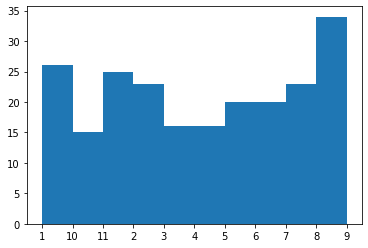

In [50]:
_ = plt.hist(list(DataSplit['test'].values()))

# In truth it's not. If we look at the actual labels:

In [52]:
sample = next(iter(TestDataLoader))
sample['label']

tensor([5, 5, 5, 5, 5, 5, 5, 5, 5, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2])

The mapping of the test dataset should have been done based on the ground truth labels.